In [1]:
import os

import keras

from classification_models.keras import Classifiers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
from keras.optimizers import SGD

Using TensorFlow backend.


### Configurações de treino

In [2]:
def tl_scheduler(epoch):
    if epoch < 6:
        return 0.005
    elif epoch < 11:
        return 0.001
    elif epoch < 21:
        return 0.005
    elif epoch < 28:
        return 0.001
    elif epoch < 36:
        return 0.0005
    else:
        return 0.0001


In [3]:
training_config = {
    'batch_size': 128,
    'target_size': (224,224),
    'epochs': 55,
    'lr': 0.005,
    'decay': 0,
    'seed': 42
}

### Carregando Dataset

In [4]:
experiments_path = '/data/alberto/iWildCam2020/experiments'
experiment = 'resnet18_iwild205_21042020'

In [5]:
train_dir = '/data/alberto/iWildCam2020/resized/train_resized'
validation_dir = '/data/alberto/iWildCam2020/resized/validation_resized'

In [6]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        shuffle=True,
        seed=training_config['seed'])

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        classes=sorted(list(train_generator.class_indices.keys())))

Found 203689 images belonging to 203 classes.
Found 56736 images belonging to 203 classes.


### Calbacks

In [7]:
model_path = os.path.join(experiments_path, experiment, 'models', 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5')
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy'
)

checkpoint_best = ModelCheckpoint(
    filepath=os.path.join(experiments_path, experiment, 'models', 'best.hdf5'),
    save_best_only=True,
    monitor='val_accuracy'
)

csv_path = os.path.join(experiments_path, experiment, 'history', 'training.log')
if not os.path.exists(os.path.dirname(csv_path)):
    os.makedirs(os.path.dirname(csv_path))

csv_logger = CSVLogger(csv_path, append=True)

lr_scheduler = LearningRateScheduler(tl_scheduler)

In [8]:
callbacks = [checkpoint, checkpoint_best, csv_logger, lr_scheduler]

### Definindo Métricas

In [9]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Preparando modelo 

In [10]:
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [11]:
base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(validation_generator.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [12]:
for layer in model.layers:
    layer.trainable = True

In [13]:
optimizer = SGD(lr=training_config['lr'], momentum=0.9, decay=0)

In [14]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

In [15]:
current_epoch = 0

### Treinando modelo

In [16]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n // training_config['batch_size'],
            epochs=training_config['epochs'],
            validation_data=validation_generator,
            validation_steps=validation_generator.n // training_config['batch_size'],
            callbacks=callbacks,
            initial_epoch=current_epoch,
            use_multiprocessing=True,
            workers=8)

Epoch 1/55
1591/1591 [==============================] - 841s 528ms/step - loss: 0.9505 - accuracy: 0.7537 - top_5_accuracy: 0.9116 - val_loss: 0.7410 - val_accuracy: 0.7569 - val_top_5_accuracy: 0.9198
Epoch 2/55
1591/1591 [==============================] - 836s 525ms/step - loss: 0.5363 - accuracy: 0.8458 - top_5_accuracy: 0.9676 - val_loss: 0.7465 - val_accuracy: 0.7939 - val_top_5_accuracy: 0.9479
Epoch 3/55
1591/1591 [==============================] - 837s 526ms/step - loss: 0.4117 - accuracy: 0.8771 - top_5_accuracy: 0.9814 - val_loss: 0.5946 - val_accuracy: 0.8187 - val_top_5_accuracy: 0.9544
Epoch 4/55
1591/1591 [==============================] - 837s 526ms/step - loss: 0.3302 - accuracy: 0.8987 - top_5_accuracy: 0.9887 - val_loss: 0.5458 - val_accuracy: 0.8257 - val_top_5_accuracy: 0.9535
Epoch 5/55
1591/1591 [==============================] - 838s 527ms/step - loss: 0.2732 - accuracy: 0.9157 - top_5_accuracy: 0.9926 - val_loss: 0.9649 - val_accuracy: 0.8443 - val_top_5_accurac

### Analisando dados pós-treinamento

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

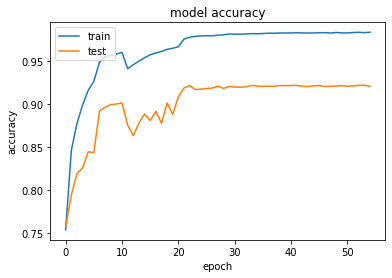

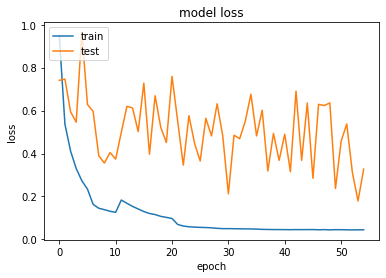

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Gerando matriz de confusão

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.n // training_config['batch_size']+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 1  8  2 ...  0  5  0]
 [10 38 11 ...  0 24  1]
 [ 3 17  3 ...  1 17  0]
 ...
 [ 0  1  0 ...  0  0  0]
 [ 3 31  5 ...  1 18  0]
 [ 0  0  0 ...  0  0  0]]


In [43]:
#print('Classification Report')
#target_names = ['empty', 'resto dos animais']
#print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [32]:
cm=confusion_matrix(validation_generator.classes, y_pred)

In [47]:
#from mlxtend.plotting import plot_confusion_matrix
#fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 10))
#plt.show()